In [565]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_validate, KFold, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import SCORERS, recall_score, precision_score, roc_auc_score, r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
load_dotenv()
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

In [518]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append('../src')

from data import make_dataset
from models import evaluation

%aimport data.make_dataset
%aimport models.evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [421]:
pd.set_option('display.max_columns', 60)

# Fetch Data

In [313]:
model_data = make_dataset.run(
    collection='climate_submissions',
    media_tags=[
        'tag_technorati_uspolitics_20100709',
        'tag_none',
        'tag_print_native',
        'tag_national',
        'tag_geo_USA',
        'tag_en',
        'tag_United States'
    ],
    entities=[
        'Misinformation',
        'Sweden',
        'Photograph',
        'Property',
        'Tourism',
        'Sustainable development',
    ],
    topics=[
        'Culture',
        'Technology',
        'Belief',
        'Violence',
        'Politics',
        'Science',
        'Nature',
        'Law',
        'Business',
        'Arts',
        'Health',
    ],
    preceeding_activity_minutes=30
)

done with fetching


../src/data/make_dataset.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_action='ignore')
../src/data/make_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_action='ignore')


done making other data sets


In [319]:
baseline_df = model_data.dropna(subset=['fb_interactions'])

In [414]:
baseline_df['comm_per_post_30'] = baseline_df.num_comm_30 / baseline_df.num_sub_30

In [587]:
baseline_df['interactions'] = baseline_df.num_comments + baseline_df.score

In [596]:
baseline_df['log_comments'] = np.log(baseline_df.num_comments + 1)

In [586]:
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 872
Data columns (total 64 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   _id                                 800 non-null    object        
 1   created_utc                         800 non-null    int64         
 2   num_comments                        800 non-null    int64         
 3   score                               800 non-null    int64         
 4   url                                 800 non-null    object        
 5   sentiment_score                     800 non-null    float64       
 6   text                                800 non-null    object        
 7   tones                               800 non-null    object        
 8   fb_interactions                     800 non-null    object        
 9   num_images                          800 non-null    int64         
 10  facebookInteractionCount  

# Data Validation

## Article Length

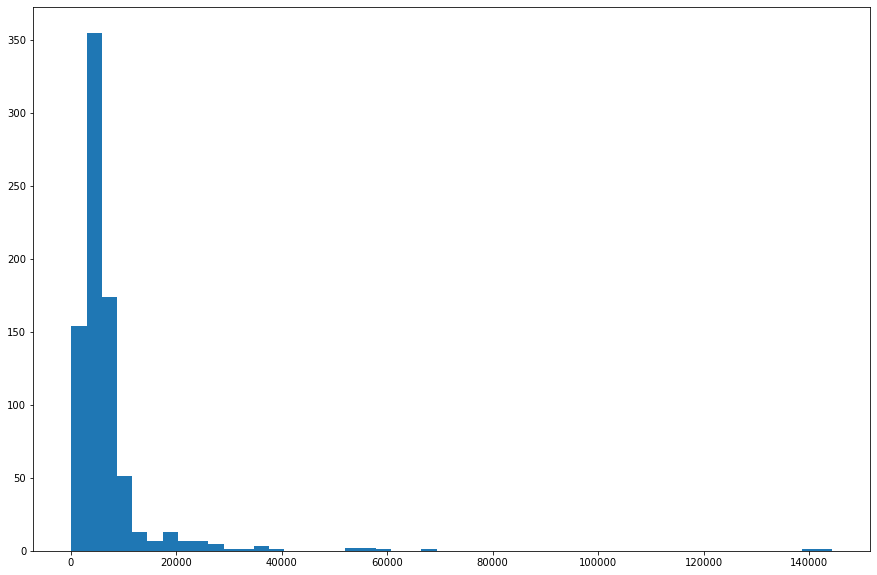

In [408]:
plt.figure(figsize=(15,10))
plt.hist(baseline_df.article_length, bins=50);
# lazy - drop anything above 30000
# less lazy - drop anything that's daily mail, independent above 10000 and drop anything else above 40k

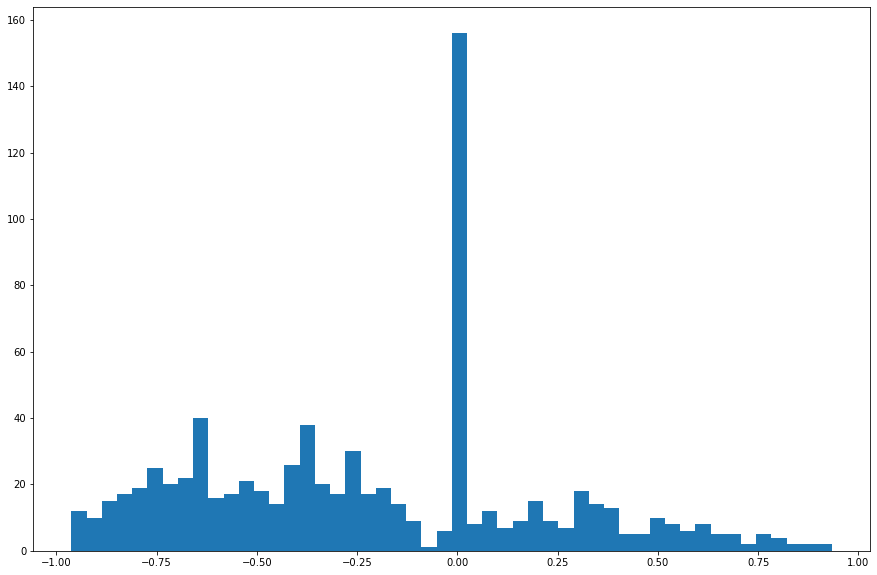

In [410]:
plt.figure(figsize=(15,10))
plt.hist(baseline_df.sentiment_score, bins=50);

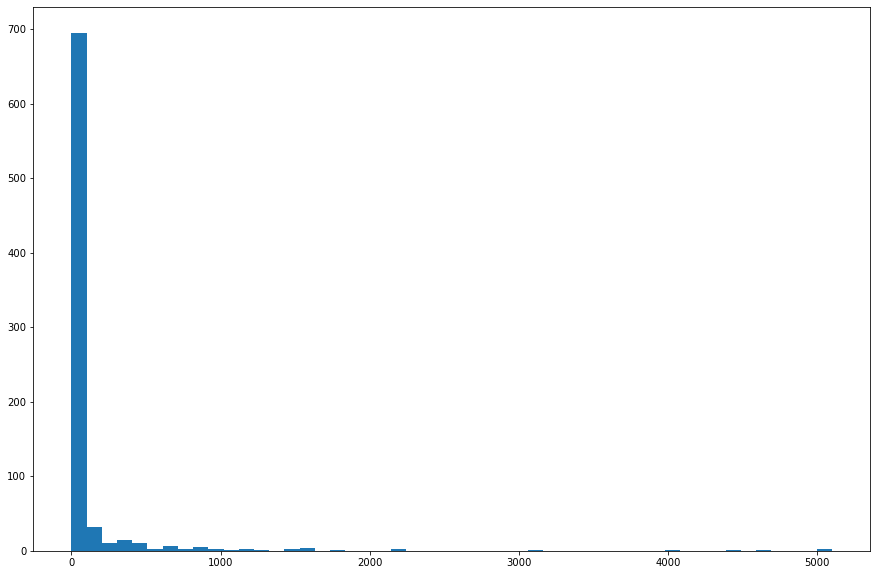

In [411]:
plt.figure(figsize=(15,10))
plt.hist(baseline_df.num_comments, bins=50);

# EDA

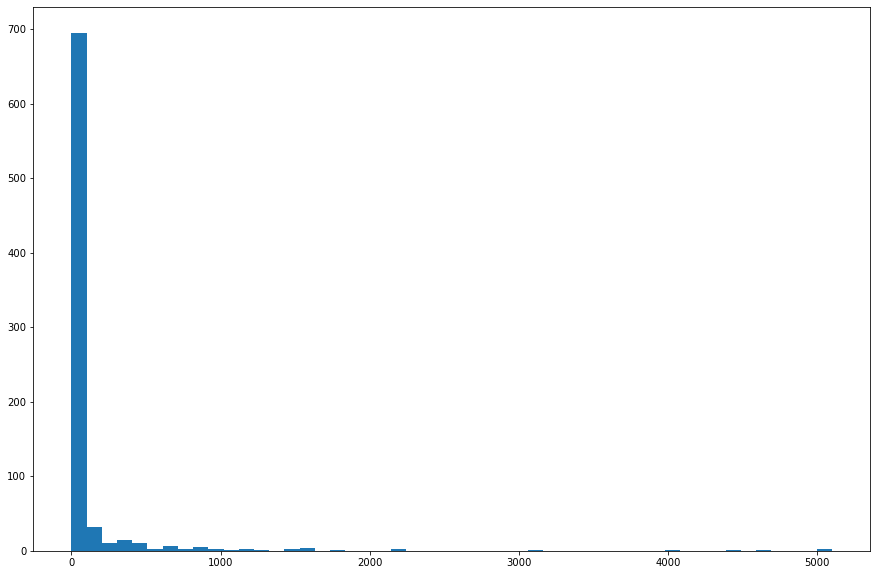

In [593]:
plt.figure(figsize=(15, 10))
plt.hist(baseline_df.num_comments, bins=50);

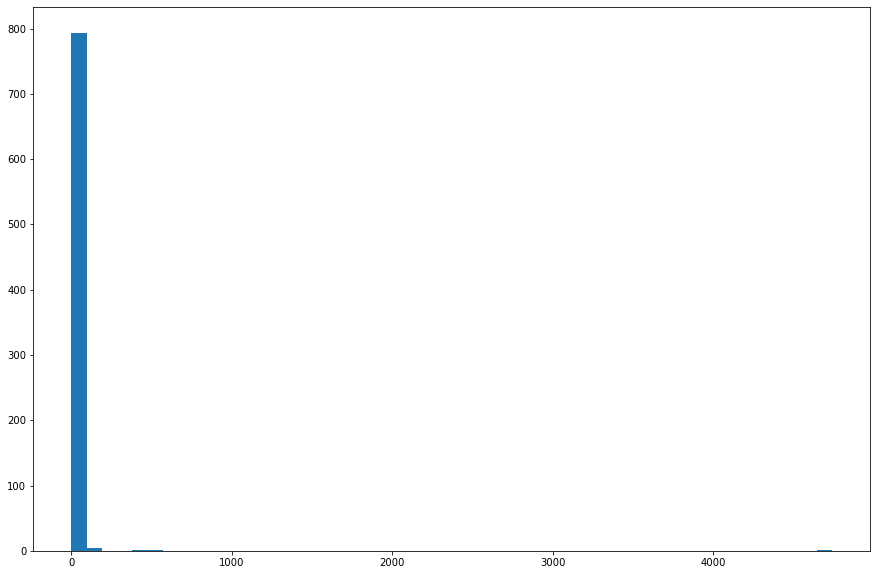

In [595]:
plt.figure(figsize=(15, 10))
plt.hist(baseline_df.score, bins=50);

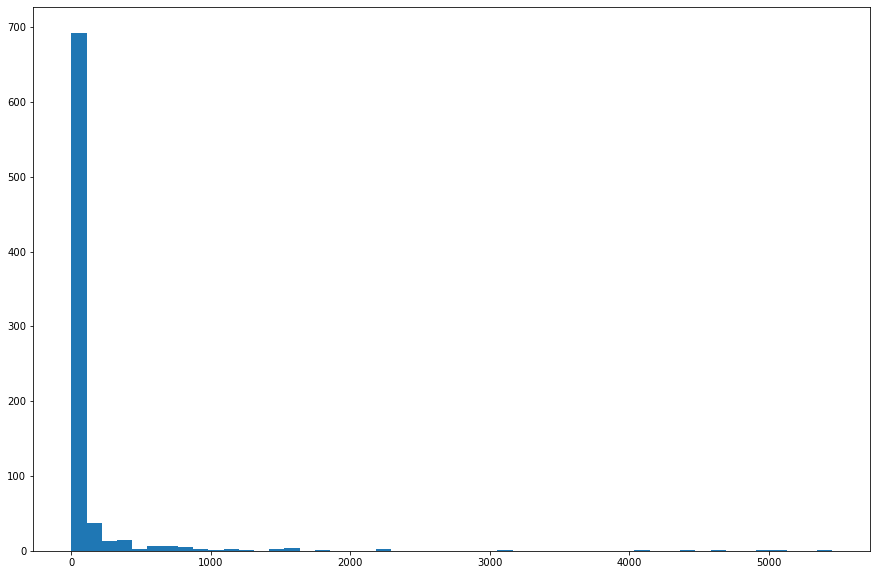

In [594]:
plt.figure(figsize=(15, 10))
plt.hist(baseline_df.interactions, bins=50);

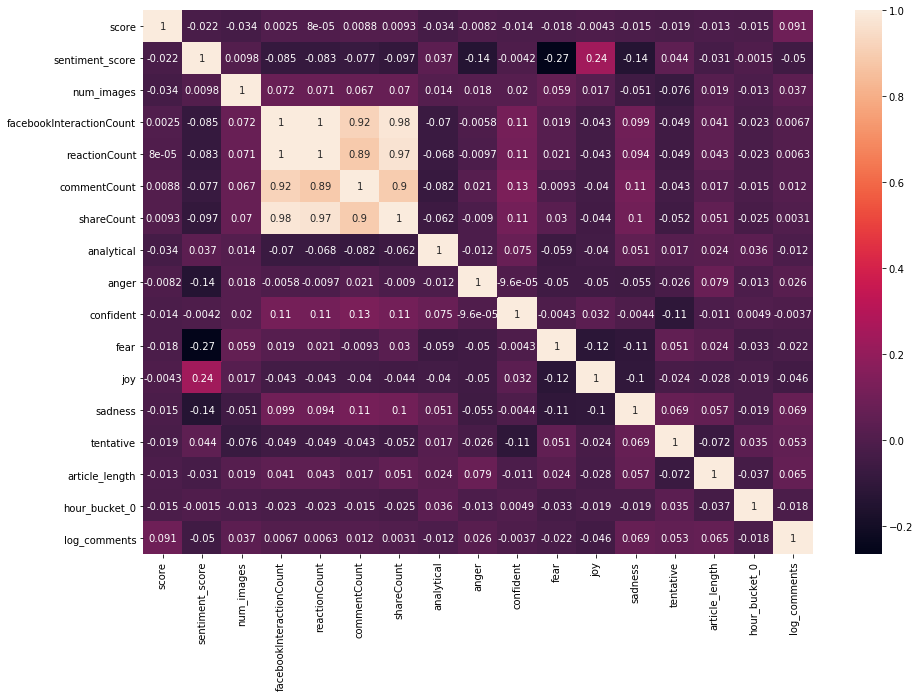

In [598]:
plt.figure(figsize=(15, 10))
sns.heatmap(baseline_df[list(baseline_df.columns[3:24]) + ['log_comments']].corr(), annot=True)

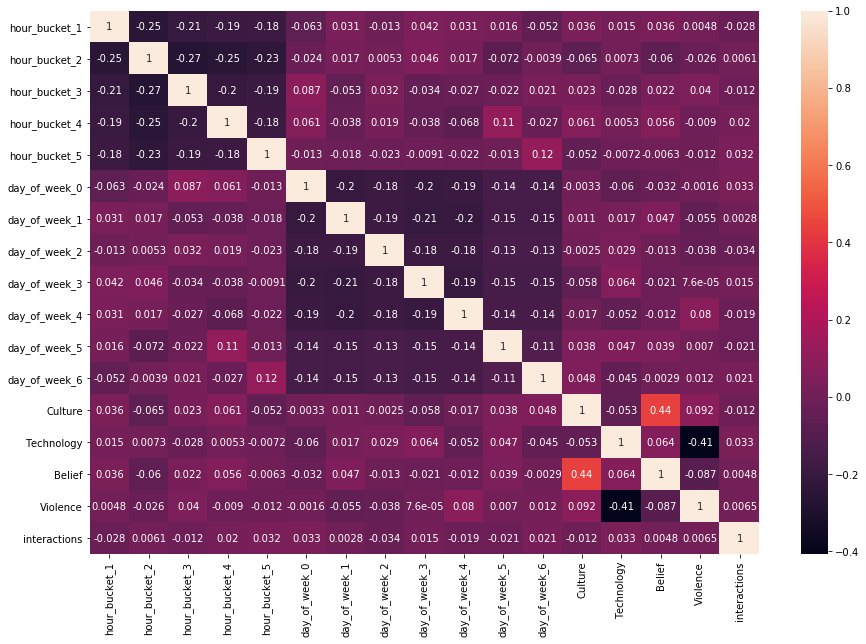

In [589]:
plt.figure(figsize=(15, 10))
sns.heatmap(baseline_df[list(baseline_df.columns[24:40]) + ['interactions']].corr(), annot=True)

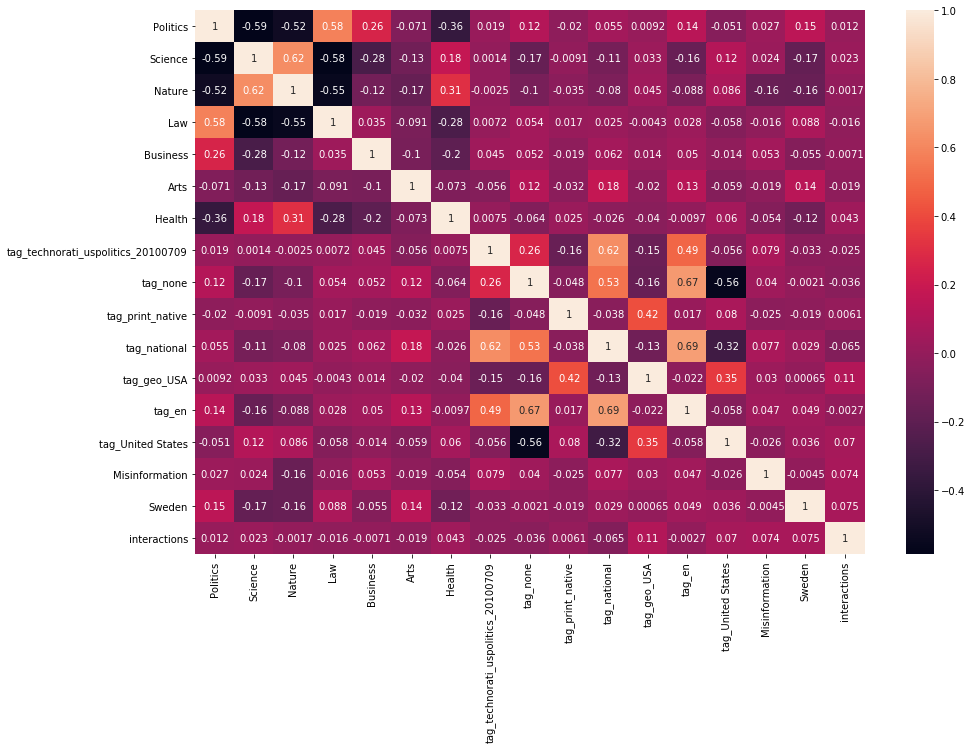

In [590]:
plt.figure(figsize=(15, 10))
sns.heatmap(baseline_df[list(baseline_df.columns[40:56]) + ['interactions']].corr(), annot=True)

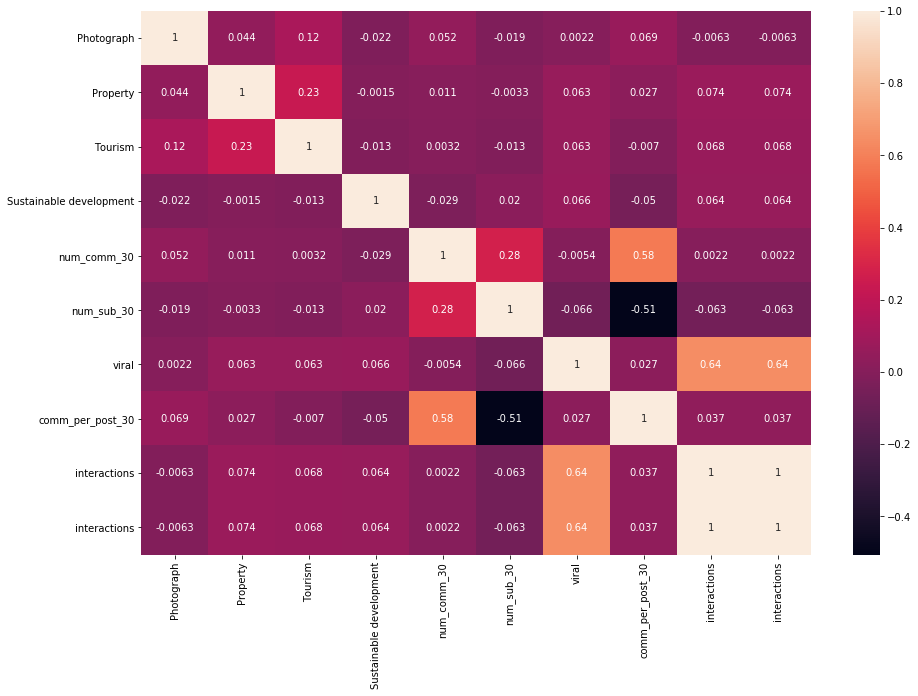

In [591]:
plt.figure(figsize=(15, 10))
sns.heatmap(baseline_df[list(baseline_df.columns[56:]) + ['interactions']].corr(), annot=True)

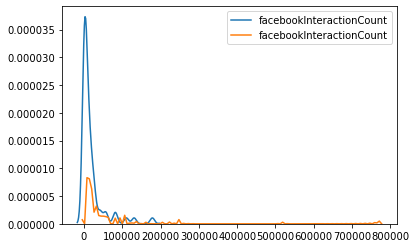

In [433]:
sns.kdeplot(baseline_df[baseline_df.num_comments > 300].facebookInteractionCount)
sns.kdeplot(baseline_df[baseline_df.num_comments < 300].facebookInteractionCount)

# Baseline Model

In [ ]:
baseline_df = baseline_df.fillna(0)

## Classification

In [507]:
X_class, y_class = baseline_df.drop(columns=[
    'created_utc',
    'text',
    'num_comments',
    'score',
    'url',
    '_id',
    'tones',
    'fb_interactions',
    'post_date',
    'viral'
]), baseline_df.viral
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=baseline_df.viral)

In [570]:
cv_res = evaluation.cross_validate(
    estimator=RandomForestClassifier,
    X=X_train_cl,
    y=y_train_cl,
    scoring=['roc_auc'],
    fit_params={
        'max_depth': 2,
        'n_estimators': 200
    },
    oversample=True,
#         show_conf_matrices=True
)

In [571]:
np.mean(cv_res['test_roc_auc'])

0.621329329803906

In [584]:
sorted(zip(X_train_cl.columns, cv_res['estimators'][0].feature_importances_), key=lambda x: -x[1])

[('commentCount', 0.13547286918075777),
 ('hour_bucket_3', 0.09319278281668959),
 ('facebookInteractionCount', 0.08836881855958059),
 ('num_sub_30', 0.08360791647325448),
 ('shareCount', 0.07829288524754037),
 ('reactionCount', 0.06488221563267624),
 ('comm_per_post_30', 0.05866261834742914),
 ('Science', 0.041472292672263045),
 ('Technology', 0.03849402578119022),
 ('Business', 0.034066330287051846),
 ('article_length', 0.027285667399374474),
 ('sentiment_score', 0.025692664750953817),
 ('Culture', 0.02197027798395675),
 ('Law', 0.020588414255552395),
 ('Health', 0.01722699994865275),
 ('tentative', 0.013883262668523286),
 ('Violence', 0.013421325885808655),
 ('tag_United States', 0.013022606839808402),
 ('joy', 0.011799636639285498),
 ('num_comm_30', 0.011342393477905869),
 ('tag_en', 0.010028871858985565),
 ('Sustainable development', 0.009484632935494442),
 ('Sweden', 0.00904250615611744),
 ('Politics', 0.008233929163108014),
 ('Nature', 0.0056456939447375966),
 ('anger', 0.0056375

In [534]:
# baseline => pretty bad but not nothing

## Regression

In [599]:
X_reg, y_reg = baseline_df[[
    'sentiment_score',
    'commentCount',
    'sadness',
    'article_length',
    'tag_print_native',
    'tag_national',
    'tag_geo_USA',
    'Misinformation',
    'Sweden',
    'Property',
    'Tourism',
    'Sustainable development',
    'num_sub_30',
]], baseline_df.log_comments
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [604]:
reg_results = cross_validate(
    estimator=RandomForestRegressor(max_depth=3, random_state=42, n_estimators=100),
    X=X_train_reg,
    y=y_train_reg,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'],
    return_train_score=True
)

In [606]:
reg_results

{'fit_time': array([0.19426608, 0.14960575, 0.15065122, 0.17238498, 0.23221707]),
 'score_time': array([0.02331591, 0.02754998, 0.02528   , 0.04244208, 0.06261182]),
 'test_r2': array([0.01189167, 0.03752431, 0.05994324, 0.06630817, 0.06216217]),
 'train_r2': array([0.22041976, 0.21467862, 0.20517737, 0.17106529, 0.19359577]),
 'test_neg_mean_absolute_error': array([-1.54154438, -1.2676174 , -1.52340439, -1.40585293, -1.24314893]),
 'train_neg_mean_absolute_error': array([-1.25387234, -1.31137808, -1.25277635, -1.30791115, -1.34227011]),
 'test_neg_mean_squared_error': array([-3.58734953, -2.78925891, -3.66407877, -3.19538083, -2.52240903]),
 'train_neg_mean_squared_error': array([-2.53184832, -2.69514386, -2.52152941, -2.73675475, -2.79952291])}

## Linear Regression

In [600]:
lm = LinearRegression()
reg_results = cross_validate(
    estimator=LinearRegression(),
    X=X_train_reg,
    y=y_train_reg,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'],
    return_train_score=True
)

In [601]:
reg_results

{'fit_time': array([0.03924108, 0.00260973, 0.00262213, 0.00252199, 0.00268388]),
 'score_time': array([0.00428009, 0.0057621 , 0.00316   , 0.00292683, 0.00316119]),
 'test_r2': array([-0.07457108, -0.00985398,  0.00965882, -0.01037767, -0.07301191]),
 'train_r2': array([0.05999383, 0.0391192 , 0.03477737, 0.0462845 , 0.04278751]),
 'test_neg_mean_absolute_error': array([-1.57928639, -1.29112208, -1.5332834 , -1.50367896, -1.37275593]),
 'train_neg_mean_absolute_error': array([-1.38880029, -1.45316287, -1.38509893, -1.41019518, -1.45007149]),
 'test_neg_mean_squared_error': array([-3.90125452, -2.92656142, -3.86007341, -3.45782337, -2.8859733 ]),
 'train_neg_mean_squared_error': array([-3.05286476, -3.2976461 , -3.06211369, -3.14872255, -3.32307071])}

In [549]:
# Regression totally failed (not entirely surprising given correlations)

## GLM

In [558]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_reg, y_train_reg, test_size=0.2, random_state=42)
glm_poisson = sm.GLM(y_tr, X_tr, family=sm.families.Poisson())
res = glm_poisson.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           num_comments   No. Observations:                  512
Model:                            GLM   Df Residuals:                      499
Model Family:                 Poisson   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2462e+05
Date:                Sun, 15 Mar 2020   Deviance:                   2.4718e+05
Time:                        20:29:13   Pearson chi2:                 1.99e+06
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sentiment_score           

In [561]:
poisson_coef = {
    'sentiment_score': -3.2086,
    'commentCount':  6.516e-06,
    'sadness':  0.6514,
    'article_length':  3.136e-06,
    'tag_print_native':  0.7871,
    'tag_national': -0.9121,
    'tag_geo_USA':  1.5453,
    'Misinformation':  0.1701,
    'Sweden':  0.4731,
    'Property':  0.5099,
    'Tourism':  0.3249,
    'Sustainable development': 0.6167,
    'num_sub_30':  0.0815,
}

def make_pred(row):
    pred = 0
    for k in poisson_coef.keys():
        pred += row[k] * poisson_coef[k]
    return pred

In [568]:
glm_preds = X_val.apply(make_pred, axis=1)

In [569]:
r2_score(y_val, glm_preds)

-0.054249220082301486

In [552]:
glm_gamma = sm.GLM(y_train_reg, X_train_reg, family=sm.families.Gamma())
res = glm_gamma.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           num_comments   No. Observations:                  640
Model:                            GLM   Df Residuals:                      627
Model Family:                   Gamma   Df Model:                           12
Link Function:          inverse_power   Scale:                          18.527
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Sun, 15 Mar 2020   Deviance:                       8393.3
Time:                        20:24:32   Pearson chi2:                 1.16e+04
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sentiment_score           

/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:735: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)


In [585]:
baseline_df.url[0]

'https://www.reuters.com/article/us-australia-wildfires-climate-change-an/scientists-paint-australia-fires-as-red-alert-on-climate-change-idUSKBN1ZB00Y?utm_source=reddit.com'

**things to try**

- Look at Austin's data
- Get reddit data from crowd tangle
- Fix bad data (length of article and maybe others)
- Try different subreddit
- Learn more about reddit visibility
- Brainstorm other predictors
- Try PCA
- Feature Engineering:
    - Comments/Post in last 30 min
- Try different models
    - GLM with gaussian
- Run grid search on models
- Try anomaly detection
- Drastically simplify
- Look at popular articles and see if you can notice any patterns
- make sure you didn't screw up and mix up the data and the labels